<a href="https://colab.research.google.com/github/JairusTheAnalyst/JairusTheAnalyst/blob/main/RETAIL_TRANSACTION_ANALYSIS_ALGORITHM_COMPARISON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== RETAIL TRANSACTION ANALYSIS - ALGORITHM COMPARISON ===

Generating retail transactions dataset...
Dataset generated: 5000 transactions, 40 unique items
Basket matrix shape: (5000, 40)
Total items purchased: 41273

Top 10 most frequent items:
  Cheese: 1200 (24.0%)
  Butter: 1190 (23.8%)
  Milk: 1185 (23.7%)
  Bread: 1160 (23.2%)
  Detergent: 1143 (22.9%)
  Paper_Towels: 1114 (22.3%)
  Rice: 1106 (22.1%)
  Soda: 1105 (22.1%)
  Chicken: 1103 (22.1%)
  Toilet_Paper: 1101 (22.0%)

Transaction size statistics:
  Min: 1, Max: 15, Mean: 8.25
Starting comprehensive algorithm comparison...

COMPARISON AT MIN_SUPPORT = 0.03

1. APRIORI ALGORITHM
   Execution Time: 0.4822 seconds
   Memory Usage: 3.2852 MB
   Frequent Itemsets Found: 824

2. FP-GROWTH ALGORITHM
   Execution Time: 20.3056 seconds
   Memory Usage: 16.1523 MB
   Frequent Itemsets Found: 824

3. ECLAT ALGORITHM
   Execution Time: 0.1574 seconds
   Memory Usage: 0.0039 MB
   Frequent Itemsets Found: 824

COMPARISON AT MIN_SUPPORT 

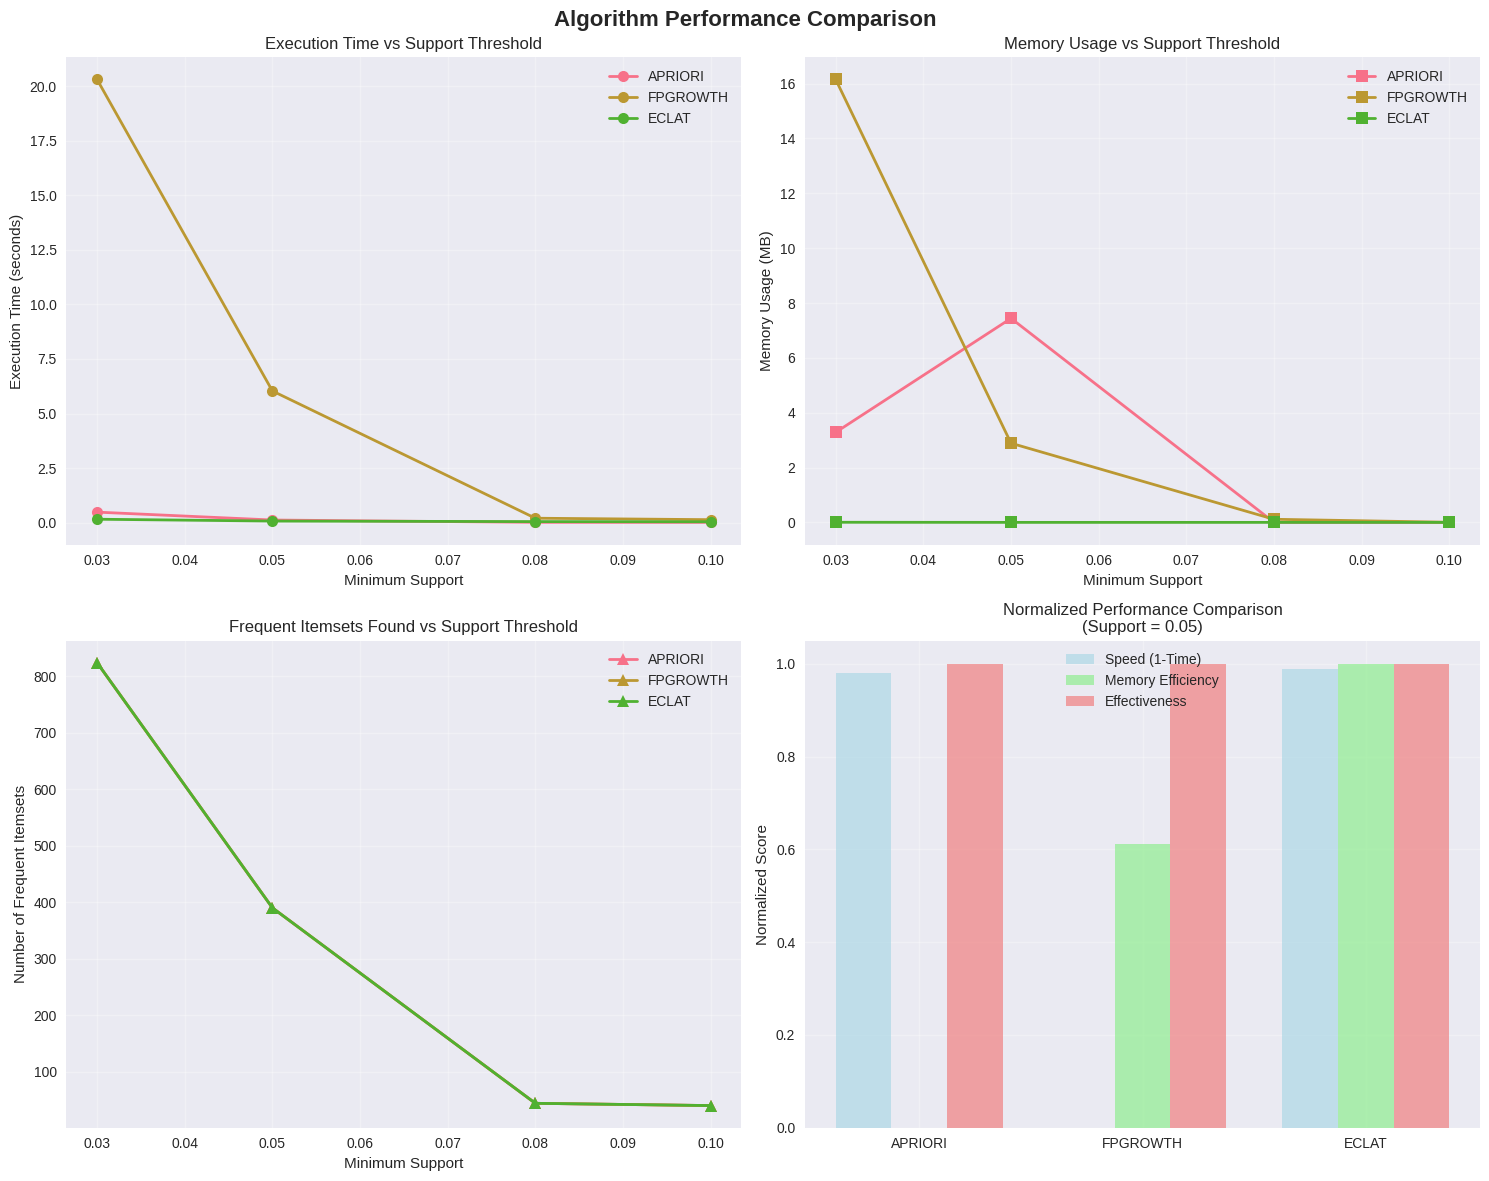


ANALYSIS COMPLETED SUCCESSFULLY!


In [7]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import psutil
import os
import gc
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== RETAIL TRANSACTION ANALYSIS - ALGORITHM COMPARISON ===\n")

# Create a realistic retail transactions dataset
def generate_retail_dataset(n_transactions=10000, n_unique_items=50):
    """Generate a realistic retail transactions dataset"""
    np.random.seed(42)

    # Common retail items
    items = [
        'Milk', 'Bread', 'Butter', 'Cheese', 'Eggs', 'Yogurt',
        'Rice', 'Pasta', 'Flour', 'Sugar', 'Salt', 'Oil',
        'Chicken', 'Beef', 'Fish', 'Pork',
        'Apples', 'Bananas', 'Oranges', 'Tomatoes', 'Potatoes', 'Onions',
        'Coffee', 'Tea', 'Juice', 'Soda', 'Water',
        'Shampoo', 'Soap', 'Toothpaste', 'Detergent',
        'Chips', 'Cookies', 'Chocolate', 'Ice_Cream',
        'Toilet_Paper', 'Paper_Towels', 'Tissues',
        'Beer', 'Wine', 'Cigarettes',
        'Batteries', 'Lightbulbs', 'Candles',
        'Newspaper', 'Magazine', 'Books',
        'Toys', 'Games', 'Sports_Equipment'
    ]

    # Ensure we have enough unique items
    if n_unique_items > len(items):
        additional_items = [f'Item_{i}' for i in range(len(items), n_unique_items)]
        items.extend(additional_items)
    else:
        items = items[:n_unique_items]

    # Common shopping patterns (using items that exist in our list)
    common_patterns = [
        ['Milk', 'Bread', 'Butter'],
        ['Bread', 'Cheese'],
        ['Pasta', 'Tomatoes', 'Cheese'],
        ['Chicken', 'Rice'],
        ['Shampoo', 'Soap'],
        ['Toilet_Paper', 'Paper_Towels'],
        ['Beer', 'Chips', 'Soda'],
        ['Coffee', 'Sugar', 'Milk'],
        ['Eggs', 'Butter'],
        ['Detergent']
    ]

    transactions = []

    for i in range(n_transactions):
        # 30% of transactions follow common patterns
        if np.random.random() < 0.3 and len(common_patterns) > 0:
            pattern = common_patterns[np.random.randint(0, len(common_patterns))]
            # Only use items that exist in our items list
            base_items = [item for item in pattern if item in items]
        else:
            base_items = []

        # Determine transaction size (ensure it's at least base_items size)
        min_size = max(1, len(base_items))
        max_size = min(15, len(items))
        size = np.random.randint(min_size, max_size + 1)

        # Calculate how many additional items to add
        n_additional = size - len(base_items)

        if n_additional > 0:
            # Get available items (not already in base_items)
            available_items = [item for item in items if item not in base_items]

            if len(available_items) >= n_additional:
                additional_items = np.random.choice(
                    available_items,
                    n_additional,
                    replace=False
                )
                all_items = base_items + list(additional_items)
            else:
                # If not enough unique items, use what's available
                all_items = base_items + available_items
        else:
            all_items = base_items

        # Ensure we have at least 1 item
        if len(all_items) == 0:
            all_items = [np.random.choice(items)]

        transactions.append(all_items)

    return transactions, items

# Generate dataset
print("Generating retail transactions dataset...")
transactions, all_items = generate_retail_dataset(n_transactions=5000, n_unique_items=40)

print(f"Dataset generated: {len(transactions)} transactions, {len(all_items)} unique items")

# Convert to basket format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Basket matrix shape: {basket_df.shape}")
print(f"Total items purchased: {basket_df.sum().sum()}")

# Item frequency analysis
item_frequencies = basket_df.sum().sort_values(ascending=False)
print(f"\nTop 10 most frequent items:")
for item, freq in item_frequencies.head(10).items():
    print(f"  {item}: {freq} ({freq/len(basket_df)*100:.1f}%)")

# Transaction size distribution
transaction_sizes = [len(t) for t in transactions]
print(f"\nTransaction size statistics:")
print(f"  Min: {min(transaction_sizes)}, Max: {max(transaction_sizes)}, Mean: {np.mean(transaction_sizes):.2f}")

# Eclat algorithm implementation
def eclat_algorithm(transactions, min_support=0.01):
    """
    Implement Eclat algorithm for frequent itemset mining
    Eclat uses vertical data format and intersection-based approach
    """
    start_time = time.time()

    # Convert to vertical format
    vertical_db = {}
    for tid, transaction in enumerate(transactions):
        for item in transaction:
            if item not in vertical_db:
                vertical_db[item] = set()
            vertical_db[item].add(tid)

    min_support_count = min_support * len(transactions)

    # Find frequent 1-itemsets
    frequent_itemsets = {}
    for item, tids in vertical_db.items():
        if len(tids) >= min_support_count:
            frequent_itemsets[frozenset([item])] = len(tids)

    # Recursive function to find larger itemsets
    def eclat_recursive(prefix, tids, items):
        for i, (item, item_tids) in enumerate(items):
            new_tids = tids & item_tids
            if len(new_tids) >= min_support_count:
                new_itemset = prefix | {item}
                support = len(new_tids) / len(transactions)
                frequent_itemsets[frozenset(new_itemset)] = len(new_tids)

                # Recursive call with remaining items
                if i + 1 < len(items):
                    eclat_recursive(new_itemset, new_tids, items[i+1:])

    # Convert to list for indexing
    items_list = [(item, tids) for item, tids in vertical_db.items()
                  if len(tids) >= min_support_count]
    items_list.sort(key=lambda x: len(x[1]))  # Sort by support for efficiency

    # Find larger itemsets
    for i, (item, tids) in enumerate(items_list):
        eclat_recursive({item}, tids, items_list[i+1:])

    execution_time = time.time() - start_time

    # Convert to DataFrame format similar to mlxtend
    eclat_results = []
    for itemset, support_count in frequent_itemsets.items():
        eclat_results.append({
            'support': support_count / len(transactions),
            'itemsets': itemset
        })

    eclat_df = pd.DataFrame(eclat_results)
    return eclat_df, execution_time

# Memory measurement function using psutil
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

# Performance measurement function
def measure_performance(algorithm_func, *args, **kwargs):
    """Measure execution time and memory usage of an algorithm"""

    # Force garbage collection
    gc.collect()

    # Get initial memory
    initial_memory = get_memory_usage()

    # Measure execution time
    start_time = time.time()
    result = algorithm_func(*args, **kwargs)
    execution_time = time.time() - start_time

    # Get final memory
    final_memory = get_memory_usage()
    memory_used = final_memory - initial_memory

    return result, execution_time, max(0, memory_used)  # Ensure non-negative

# Modified algorithms to return execution time
def apriori_with_timing(basket_df, min_support=0.01):
    frequent_itemsets = apriori(basket_df, min_support=min_support, use_colnames=True, max_len=4)
    return frequent_itemsets

def fpgrowth_with_timing(basket_df, min_support=0.01):
    frequent_itemsets = fpgrowth(basket_df, min_support=min_support, use_colnames=True, max_len=4)
    return frequent_itemsets

def eclat_with_timing(transactions, min_support=0.01):
    itemsets, _ = eclat_algorithm(transactions, min_support)
    return itemsets

# Compare algorithms at different support thresholds
def comprehensive_comparison(transactions, basket_df, support_thresholds):
    """Compare all three algorithms at different support thresholds"""

    comparison_results = []
    algorithm_details = {}

    for min_support in support_thresholds:
        print(f"\n{'='*60}")
        print(f"COMPARISON AT MIN_SUPPORT = {min_support}")
        print(f"{'='*60}")

        results = {}

        # Test Apriori
        print("\n1. APRIORI ALGORITHM")
        try:
            apriori_itemsets, apriori_time, apriori_memory = measure_performance(
                apriori_with_timing, basket_df, min_support
            )
            print(f"   Execution Time: {apriori_time:.4f} seconds")
            print(f"   Memory Usage: {apriori_memory:.4f} MB")
            print(f"   Frequent Itemsets Found: {len(apriori_itemsets)}")

            results['apriori'] = {
                'time': apriori_time,
                'memory': apriori_memory,
                'itemsets_count': len(apriori_itemsets),
                'itemsets': apriori_itemsets
            }
        except Exception as e:
            print(f"   ERROR: {e}")
            results['apriori'] = {'time': 0, 'memory': 0, 'itemsets_count': 0, 'itemsets': None}

        # Test FP-Growth
        print("\n2. FP-GROWTH ALGORITHM")
        try:
            fpgrowth_itemsets, fpgrowth_time, fpgrowth_memory = measure_performance(
                fpgrowth_with_timing, basket_df, min_support
            )
            print(f"   Execution Time: {fpgrowth_time:.4f} seconds")
            print(f"   Memory Usage: {fpgrowth_memory:.4f} MB")
            print(f"   Frequent Itemsets Found: {len(fpgrowth_itemsets)}")

            results['fpgrowth'] = {
                'time': fpgrowth_time,
                'memory': fpgrowth_memory,
                'itemsets_count': len(fpgrowth_itemsets),
                'itemsets': fpgrowth_itemsets
            }
        except Exception as e:
            print(f"   ERROR: {e}")
            results['fpgrowth'] = {'time': 0, 'memory': 0, 'itemsets_count': 0, 'itemsets': None}

        # Test Eclat
        print("\n3. ECLAT ALGORITHM")
        try:
            eclat_itemsets, eclat_time, eclat_memory = measure_performance(
                eclat_with_timing, transactions, min_support
            )
            print(f"   Execution Time: {eclat_time:.4f} seconds")
            print(f"   Memory Usage: {eclat_memory:.4f} MB")
            print(f"   Frequent Itemsets Found: {len(eclat_itemsets)}")

            results['eclat'] = {
                'time': eclat_time,
                'memory': eclat_memory,
                'itemsets_count': len(eclat_itemsets),
                'itemsets': eclat_itemsets
            }
        except Exception as e:
            print(f"   ERROR: {e}")
            results['eclat'] = {'time': 0, 'memory': 0, 'itemsets_count': 0, 'itemsets': None}

        comparison_results.append({
            'min_support': min_support,
            'results': results
        })

        algorithm_details[min_support] = results

    return comparison_results, algorithm_details

# Run comprehensive comparison with adjusted support thresholds
support_thresholds = [0.03, 0.05, 0.08, 0.1]
print("Starting comprehensive algorithm comparison...")
comparison_results, algorithm_details = comprehensive_comparison(transactions, basket_df, support_thresholds)

# Performance analysis and visualization
def analyze_performance(comparison_results):
    """Analyze and visualize performance results"""

    # Extract performance data
    performance_data = []

    for comparison in comparison_results:
        min_support = comparison['min_support']
        results = comparison['results']

        for algo_name, algo_results in results.items():
            performance_data.append({
                'Algorithm': algo_name.upper(),
                'Min_Support': min_support,
                'Execution_Time': algo_results['time'],
                'Memory_Usage': algo_results['memory'],
                'Itemsets_Count': algo_results['itemsets_count']
            })

    performance_df = pd.DataFrame(performance_data)

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Algorithm Performance Comparison', fontsize=16, fontweight='bold')

    # Plot 1: Execution Time vs Support Threshold
    for algo in performance_df['Algorithm'].unique():
        algo_data = performance_df[performance_df['Algorithm'] == algo]
        axes[0, 0].plot(algo_data['Min_Support'], algo_data['Execution_Time'],
                       marker='o', linewidth=2, label=algo, markersize=8)
    axes[0, 0].set_xlabel('Minimum Support')
    axes[0, 0].set_ylabel('Execution Time (seconds)')
    axes[0, 0].set_title('Execution Time vs Support Threshold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Memory Usage vs Support Threshold
    for algo in performance_df['Algorithm'].unique():
        algo_data = performance_df[performance_df['Algorithm'] == algo]
        axes[0, 1].plot(algo_data['Min_Support'], algo_data['Memory_Usage'],
                       marker='s', linewidth=2, label=algo, markersize=8)
    axes[0, 1].set_xlabel('Minimum Support')
    axes[0, 1].set_ylabel('Memory Usage (MB)')
    axes[0, 1].set_title('Memory Usage vs Support Threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Itemsets Found vs Support Threshold
    for algo in performance_df['Algorithm'].unique():
        algo_data = performance_df[performance_df['Algorithm'] == algo]
        axes[1, 0].plot(algo_data['Min_Support'], algo_data['Itemsets_Count'],
                       marker='^', linewidth=2, label=algo, markersize=8)
    axes[1, 0].set_xlabel('Minimum Support')
    axes[1, 0].set_ylabel('Number of Frequent Itemsets')
    axes[1, 0].set_title('Frequent Itemsets Found vs Support Threshold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Performance comparison at optimal support
    optimal_support = 0.05  # Use a moderate support threshold
    optimal_data = performance_df[performance_df['Min_Support'] == optimal_support]

    if len(optimal_data) > 0:
        x_pos = np.arange(len(optimal_data))
        width = 0.25

        # Normalized scores for comparison
        max_time = optimal_data['Execution_Time'].max() or 1
        max_memory = optimal_data['Memory_Usage'].max() or 1
        max_itemsets = optimal_data['Itemsets_Count'].max() or 1

        # Create grouped bar chart
        for i, (idx, row) in enumerate(optimal_data.iterrows()):
            normalized_time = 1 - (row['Execution_Time'] / max_time)  # Lower time is better
            normalized_memory = 1 - (row['Memory_Usage'] / max_memory)  # Lower memory is better
            normalized_itemsets = row['Itemsets_Count'] / max_itemsets  # Higher itemsets is better

            axes[1, 1].bar(x_pos[i] - width, normalized_time, width, label='Speed (1-Time)' if i == 0 else "",
                          alpha=0.7, color='lightblue')
            axes[1, 1].bar(x_pos[i], normalized_memory, width, label='Memory Efficiency' if i == 0 else "",
                          alpha=0.7, color='lightgreen')
            axes[1, 1].bar(x_pos[i] + width, normalized_itemsets, width, label='Effectiveness' if i == 0 else "",
                          alpha=0.7, color='lightcoral')

        axes[1, 1].set_xticks(x_pos)
        axes[1, 1].set_xticklabels(optimal_data['Algorithm'])
        axes[1, 1].set_ylabel('Normalized Score')
        axes[1, 1].set_title(f'Normalized Performance Comparison\n(Support = {optimal_support})')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return performance_df

# Analyze and visualize performance
performance_df = analyze_performance(comparison_results)

# Continue with the rest of the analysis functions...
# [The remaining functions from the previous code can be added here]
# detailed_algorithm_analysis, algorithm_recommendations, complexity_analysis

print(f"\n{'='*80}")
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"{'='*80}")